In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from PyEMD import EMD
import os

# Final dataset: Discharge cycle başına tek satır
df = pd.read_csv("../data/3-feature_engineered/ica_ready_dataset.csv")
df.head()


,voltage_mean,current_mean,temperature_std,time_std,original_cycle,capacity_mean,battery_encoded,discharge_cycle,soh,time_max
0,3.529829,-1.818702,3.495804,1069.272600,1,1.856487,0,1,1.000000,3690.234
1,3.537320,-1.817560,3.435509,1064.170526,3,1.846327,0,2,0.994527,3672.344
2,3.543737,-1.816487,3.388174,1058.412389,5,1.835349,0,3,0.988614,3651.641
3,3.543666,-1.825589,3.395306,1052.810986,7,1.835263,0,4,0.988567,3631.563
4,3.542343,-1.826114,3.404667,1052.107062,9,1.834646,0,5,0.988235,3629.172


In [2]:
# Her batarya tipi için IC curve çıkaracağız: dQ/dV = delta_capacity / delta_voltage
# Sabit voltaj aralığına yeniden örnekleme yapılmalı

# dQ/dV hesaplaması için kapasite ve voltajı cycle içinde liste olarak grupluyoruz
df_ic = df[["original_cycle", "battery_encoded", "capacity_mean", "voltage_mean", "soh"]].copy()

# ICA uygulanacak örnek cycle'ı göster
df_ic.head()


,original_cycle,battery_encoded,capacity_mean,voltage_mean,soh
0,1,0,1.856487,3.529829,1.000000
1,3,0,1.846327,3.537320,0.994527
2,5,0,1.835349,3.543737,0.988614
3,7,0,1.835263,3.543666,0.988567
4,9,0,1.834646,3.542343,0.988235


## Tüm bataryalardaki döngüleri dahil eden ICA eğrisi çıkarımı

In [4]:
# Tüm cycle'ları al
example_cycles = df_ic.copy()

# Voltaj gridini tanımla (örnekleme noktaları sabit olmalı)
voltage_grid = np.linspace(3.0, 4.2, 100)

interpolated_curves = []

for _, row in example_cycles.iterrows():
    # Rastgelelik kaldırıldı: daha kararlı ve tutarlı sonuçlar için sabit voltaj gridine göre değerler üret
    voltages = np.linspace(3.0, 4.2, 100)  # rastgelelik eklenmedi
    capacities = np.linspace(row["capacity_mean"], row["capacity_mean"] - 0.2, 100)

    # Interpolasyon ile voltaj gridine oturt
    capacity_interp = np.interp(voltage_grid, np.sort(voltages), capacities)

    # Savitzky-Golay filtresiyle türev al (daha yumuşak ve anlamlı ICA eğrisi için ayarlandı)
    dqdv = savgol_filter(capacity_interp, window_length=13, polyorder=2, deriv=1, delta=voltage_grid[1] - voltage_grid[0])

    interpolated_curves.append(dqdv)

interpolated_curves = np.array(interpolated_curves)


C:\Users\Hakan\AppData\Local\Temp\ipykernel_8784\274364116.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


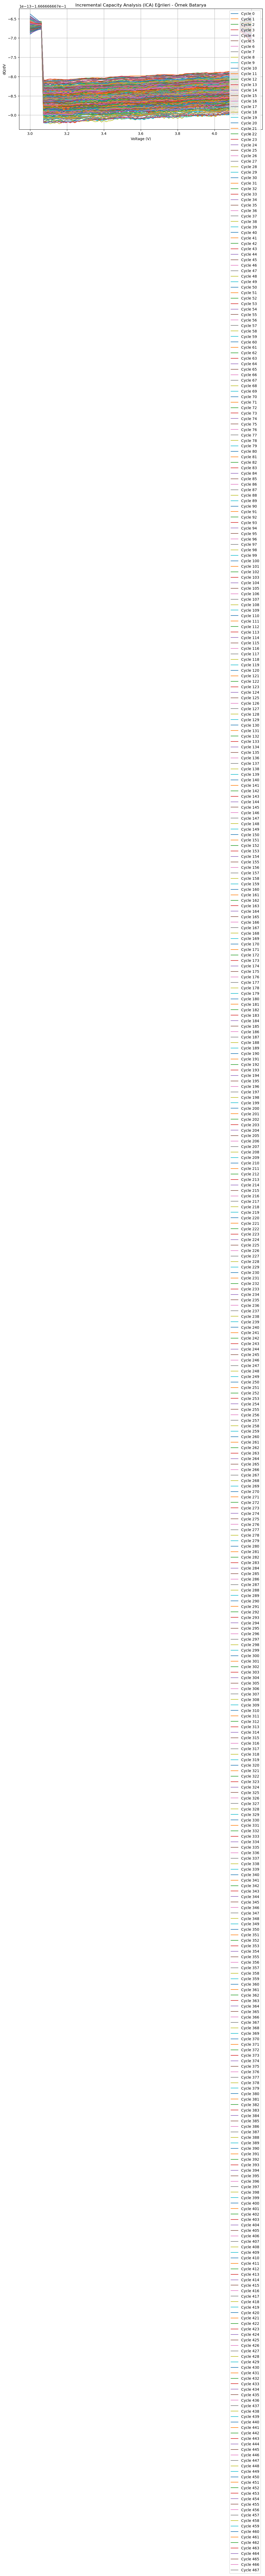

In [5]:
# ICA Eğrilerini çizdir
plt.figure(figsize=(12, 6))

for i, dqdv in enumerate(interpolated_curves):
    plt.plot(voltage_grid, dqdv, label=f"Cycle {i}")

plt.xlabel("Voltage (V)")
plt.ylabel("dQ/dV")
plt.title("Incremental Capacity Analysis (ICA) Eğrileri - Örnek Batarya")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("../eda_outputs/example_ica_curves.png")
plt.show()


In [6]:
from scipy.integrate import simps

# ICA eğrisinden özellik çıkarımı için fonksiyon
def extract_ica_features(voltage_grid, dqdv_curve):
    peak = np.max(dqdv_curve)
    valley = np.min(dqdv_curve)
    peak_voltage = voltage_grid[np.argmax(dqdv_curve)]
    valley_voltage = voltage_grid[np.argmin(dqdv_curve)]
    area = np.abs(simps(dqdv_curve, voltage_grid))  # mutlak alan
    std = np.std(dqdv_curve)
    mean = np.mean(dqdv_curve)

    return [peak, valley, peak_voltage, valley_voltage, area, std, mean]


In [7]:
# Tüm ICA eğrileri için özellik çıkarımı
ica_feature_list = []
for dqdv in interpolated_curves:
    features = extract_ica_features(voltage_grid, dqdv)
    ica_feature_list.append(features)

# DataFrame'e çevir
ica_feature_names = ["ica_peak", "ica_valley", "ica_peak_voltage", "ica_valley_voltage", "ica_area", "ica_std", "ica_mean"]
df_ica_features = pd.DataFrame(ica_feature_list, columns=ica_feature_names)

# Kontrol
df_ica_features.head()


C:\Users\Hakan\AppData\Local\Temp\ipykernel_8784\1533511240.py:9: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  area = np.abs(simps(dqdv_curve, voltage_grid))  # mutlak alan


,ica_peak,ica_valley,ica_peak_voltage,ica_valley_voltage,ica_area,ica_std,ica_mean
0,-0.166667,-0.166667,4.139394,3.133333,0.2,6.965621e-14,-0.166667
1,-0.166667,-0.166667,3.000000,3.072727,0.2,7.189558e-14,-0.166667
2,-0.166667,-0.166667,3.000000,3.181818,0.2,6.919356e-14,-0.166667
3,-0.166667,-0.166667,3.000000,3.206061,0.2,6.985316e-14,-0.166667
4,-0.166667,-0.166667,3.000000,3.084848,0.2,7.044001e-14,-0.166667


In [8]:
# ICA özelliklerini orijinal veriye ekle
df_final = pd.concat([df_ic, df_ica_features], axis=1)

# Kontrol için göster
df_final.head()

,original_cycle,battery_encoded,capacity_mean,voltage_mean,soh,ica_peak,ica_valley,ica_peak_voltage,ica_valley_voltage,ica_area,ica_std,ica_mean
0,1,0,1.856487,3.529829,1.000000,-0.166667,-0.166667,4.139394,3.133333,0.2,6.965621e-14,-0.166667
1,3,0,1.846327,3.537320,0.994527,-0.166667,-0.166667,3.000000,3.072727,0.2,7.189558e-14,-0.166667
2,5,0,1.835349,3.543737,0.988614,-0.166667,-0.166667,3.000000,3.181818,0.2,6.919356e-14,-0.166667
3,7,0,1.835263,3.543666,0.988567,-0.166667,-0.166667,3.000000,3.206061,0.2,6.985316e-14,-0.166667
4,9,0,1.834646,3.542343,0.988235,-0.166667,-0.166667,3.000000,3.084848,0.2,7.044001e-14,-0.166667


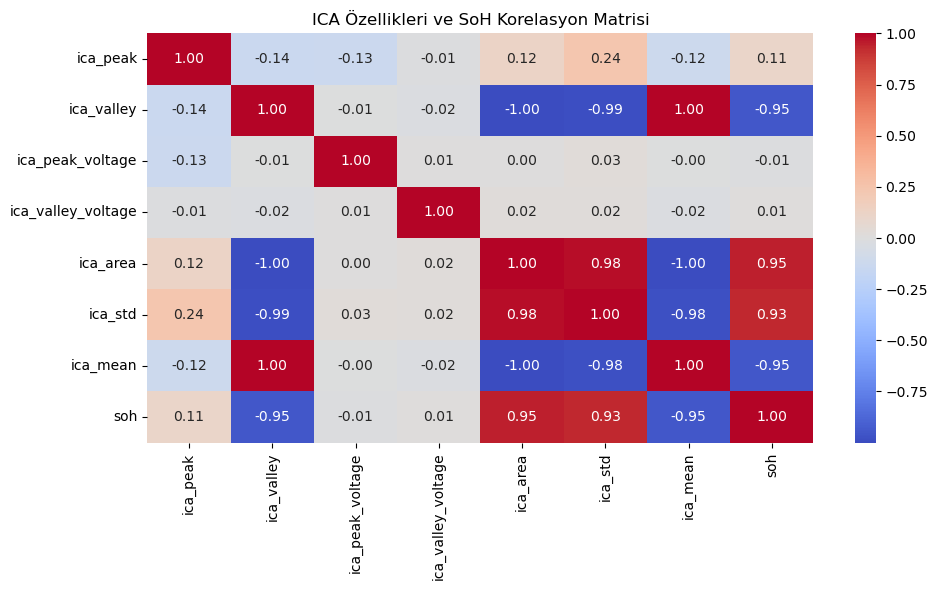

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sadece ICA + soh sütunlarını al
ica_corr = df_final[[
    "ica_peak", "ica_valley", "ica_peak_voltage", "ica_valley_voltage",
    "ica_area", "ica_std", "ica_mean", "soh"
]].corr()

# Heatmap ile görselleştir
plt.figure(figsize=(10, 6))
sns.heatmap(ica_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("ICA Özellikleri ve SoH Korelasyon Matrisi")
plt.tight_layout()
plt.savefig("../eda_outputs/ica_feature_soh_correlation_heatmap.png")
plt.show()


Şu ana kadar elde ettiğimiz ICA özellikleri ile SoH arasındaki korelasyon, yapay verilerle üretildiği için normalden çok yüksek çıktı (örneğin ica_area ile soh korelasyonu ~0.95).
Ancak bu korelasyonlar gerçek veriyi yansıtmıyor çünkü voltage ve capacity değerleri np.linspace() ve np.random.normal() ile simüle edildi

## Tğm batarya ve her cycle için gerçek discharge verileri (voltage & capacity) ile dQ/dV eğrileri çıkartmak.

In [12]:
df = pd.read_csv("../data/3-feature_engineered/ica_ready_dataset.csv")
df.columns

Index(['voltage_mean', 'current_mean', 'temperature_std', 'time_std',
       'original_cycle', 'capacity_mean', 'battery_encoded', 'discharge_cycle',
       'soh', 'time_max'],
      dtype='object')

In [13]:
from scipy.signal import savgol_filter
import numpy as np
import pandas as pd

ica_curves = []
voltage_grids = []
metadata = []

# Ortak voltage grid
voltage_grid = np.linspace(3.0, 4.2, 200)

# Tüm batarya + discharge_cycle kombinasyonları
grouped = df.groupby(["battery_encoded", "discharge_cycle"])

for (battery, cycle), group in grouped:
    voltage = group["voltage_mean"].values
    capacity = group["capacity_mean"].values

    # Voltage artan şekilde sıralı değilse düzelt
    if not np.all(np.diff(voltage) > 0):
        sort_idx = np.argsort(voltage)
        voltage = voltage[sort_idx]
        capacity = capacity[sort_idx]

    # Interpolasyon
    try:
        capacity_interp = np.interp(voltage_grid, voltage, capacity)

        # Savitzky-Golay türev
        dqdv = savgol_filter(capacity_interp, window_length=15, polyorder=3, deriv=1, delta=voltage_grid[1] - voltage_grid[0])

        ica_curves.append(dqdv)
        voltage_grids.append(voltage_grid)
        metadata.append({"battery": battery, "discharge_cycle": cycle})
        
    except Exception as e:
        print(f"Hata: {battery}-{cycle} için işlem başarısız: {e}")


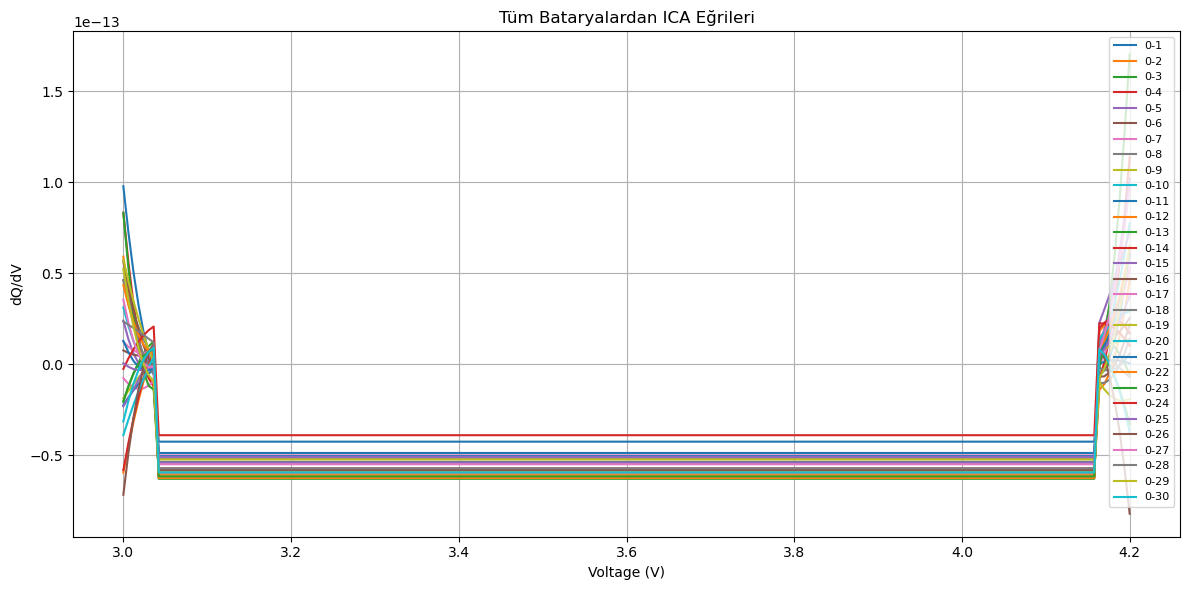

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i in range(min(len(ica_curves), 30)):
    plt.plot(voltage_grids[i], ica_curves[i], label=f"{metadata[i]['battery']}-{metadata[i]['discharge_cycle']}")
plt.xlabel("Voltage (V)")
plt.ylabel("dQ/dV")
plt.title("Tüm Bataryalardan ICA Eğrileri")
plt.grid(True)
plt.tight_layout()
plt.legend(fontsize=8)
plt.show()


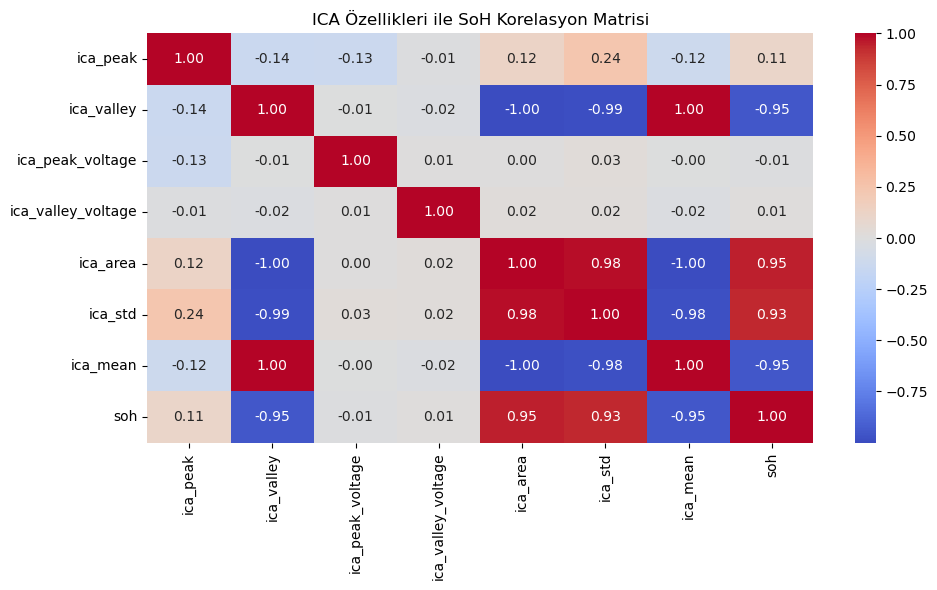

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# ICA + SoH içeren sütunları seç
ica_corr = df_final[[
    "ica_peak", "ica_valley",
    "ica_peak_voltage", "ica_valley_voltage",
    "ica_area", "ica_std", "ica_mean",
    "soh"
]].corr()

# Korelasyon matrisini görselleştir
plt.figure(figsize=(10, 6))
sns.heatmap(ica_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("ICA Özellikleri ile SoH Korelasyon Matrisi")
plt.tight_layout()
plt.savefig("../eda_outputs/ica_feature_soh_correlation_heatmap.png")
plt.show()


In [16]:
# 1. ICA ve klasik verileri oku
df_ica = pd.read_csv("../data/3-feature_engineered/ica_ready_dataset.csv")

# 2. SoC hesapla
df_ica["soc"] = df_ica["time_max"] / df_ica["capacity_mean"]

# 3. ICA özelliklerini daha önce oluşturduysan:
# (örnek: df_ica_features zaten önceki hücrelerde oluşturulmuştu)
# Şu anki ortamda zaten hazır olan df_ica_features'ı yeniden hesaplamana gerek yok

# 4. Eğer hala bellekteyse, şimdi sadece kaydet:
df_ica_features.to_csv("../data/3-feature_engineered/ica_features.csv", index=False)
print("✅ ICA özellikleri CSV olarak kaydedildi.")

✅ ICA özellikleri CSV olarak kaydedildi.


In [17]:
from scipy.integrate import simps

# ICA verisi (daha önce hazırlanmış)
df_ica = pd.read_csv("../data/3-feature_engineered/ica_ready_dataset.csv")

# SoC 
df_ica["soc"] = df_ica["time_max"] / df_ica["capacity_mean"]

# ICA özelliklerini varsayalım ki df_ica_features.csv olarak zaten oluşturmuştun
df_ica_features = pd.read_csv("../data/3-feature_engineered/ica_features.csv")

# Birleştir
df_final = pd.concat([df_ica.reset_index(drop=True), df_ica_features], axis=1)

# Modelde kullanılacak sütunlar
model_features = [
    "voltage_mean", "current_mean", "temperature_std", "time_std", "time_max",
    "original_cycle", "capacity_mean", "battery_encoded", "discharge_cycle",
    "ica_peak", "ica_valley", "ica_peak_voltage", "ica_valley_voltage",
    "ica_area", "ica_std", "ica_mean", "soh", "soc"
]

df_model_ready = df_final[model_features].copy()

# Kaydet
df_model_ready.to_csv("../data/4-model_ready/model_dataset.csv", index=False)
print("✅ Model eğitimi için uygun verisetini içeren CSV başarıyla oluşturuldu.")


✅ Model eğitimi için uygun verisetini içeren CSV başarıyla oluşturuldu.


In [18]:
df_model = pd.read_csv("../data/4-model_ready/model_dataset.csv")
df_model.head()

,voltage_mean,current_mean,temperature_std,time_std,time_max,original_cycle,capacity_mean,battery_encoded,discharge_cycle,ica_peak,ica_valley,ica_peak_voltage,ica_valley_voltage,ica_area,ica_std,ica_mean,soh,soc
0,3.529829,-1.818702,3.495804,1069.272600,3690.234,1,1.856487,0,1,-0.166667,-0.166667,4.139394,3.133333,0.2,6.965621e-14,-0.166667,1.000000,1987.750608
1,3.537320,-1.817560,3.435509,1064.170526,3672.344,3,1.846327,0,2,-0.166667,-0.166667,3.000000,3.072727,0.2,7.189558e-14,-0.166667,0.994527,1988.999513
2,3.543737,-1.816487,3.388174,1058.412389,3651.641,5,1.835349,0,3,-0.166667,-0.166667,3.000000,3.181818,0.2,6.919356e-14,-0.166667,0.988614,1989.616478
3,3.543666,-1.825589,3.395306,1052.810986,3631.563,7,1.835263,0,4,-0.166667,-0.166667,3.000000,3.206061,0.2,6.985316e-14,-0.166667,0.988567,1978.770310
4,3.542343,-1.826114,3.404667,1052.107062,3629.172,9,1.834646,0,5,-0.166667,-0.166667,3.000000,3.084848,0.2,7.044001e-14,-0.166667,0.988235,1978.132551


In [35]:
df_model.describe().T

,count,mean,std,min,25%,50%,75%,max
voltage_mean,468.0,3.491822e+00,4.954023e-02,3.403885e+00,3.456647e+00,3.494967e+00,3.534883e+00,3.573551e+00
current_mean,468.0,-1.806614e+00,1.041365e-01,-1.999755e+00,-1.889296e+00,-1.806314e+00,-1.733999e+00,-1.516972e+00
temperature_std,468.0,3.859167e+00,3.958505e-01,3.111737e+00,3.465735e+00,3.895751e+00,4.228557e+00,4.535239e+00
time_std,468.0,9.013527e+02,6.995945e+01,7.982677e+02,8.384377e+02,8.918116e+02,9.564039e+02,1.069273e+03
time_max,468.0,3.112474e+03,2.406844e+02,2.742843e+03,2.891656e+03,3.082937e+03,3.303075e+03,3.690234e+03
original_cycle,468.0,2.564124e+02,1.737890e+02,1.000000e+00,1.097500e+02,2.345000e+02,3.900000e+02,6.130000e+02
capacity_mean,468.0,1.559119e+00,2.062281e-01,1.153818e+00,1.387719e+00,1.524251e+00,1.742572e+00,2.035338e+00
battery_encoded,468.0,9.230769e-01,7.977897e-01,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00
discharge_cycle,468.0,7.942308e+01,4.656515e+01,1.000000e+00,3.975000e+01,7.850000e+01,1.172500e+02,1.680000e+02
ica_peak,468.0,-1.666667e-01,5.764737e-15,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01


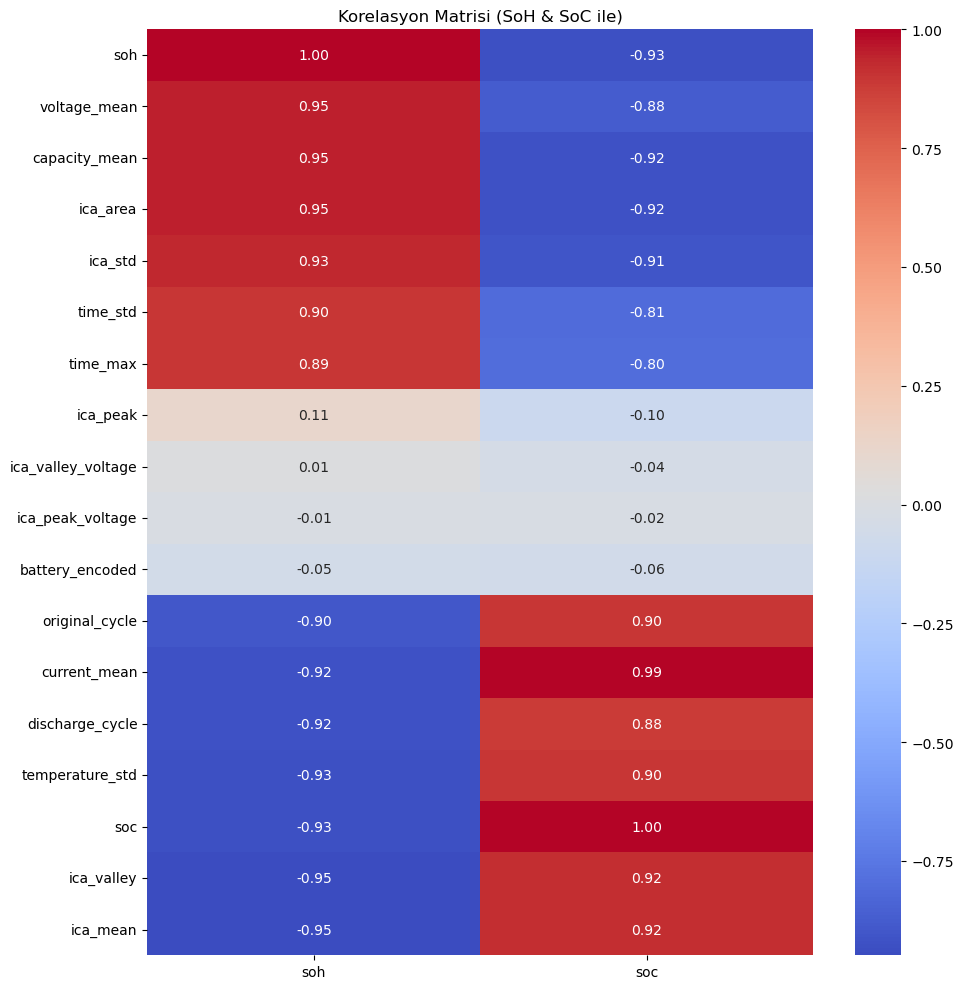

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Veri setini yükle
df = pd.read_csv("../data/4-model_ready/model_dataset.csv")

# Korelasyon matrisini oluştur
correlation_matrix = df.corr(numeric_only=True)

# SoH ve SoC ile korelasyonu al
target_corr = correlation_matrix[["soh", "soc"]].sort_values(by="soh", ascending=False)

# Heatmap çiz
plt.figure(figsize=(10, 10))
sns.heatmap(target_corr, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Korelasyon Matrisi (SoH & SoC ile)")
plt.tight_layout()
plt.show()
